In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.3.0
/device:GPU:0
Num GPUs Available:  1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pickle 
import random
import IPython
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.layers import Input, Conv2D, Lambda, Dense, Flatten, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D

In [ ]:
#Loading the Pre Processed dataset
IMAGE_A = pd.read_pickle(r'/content/drive/MyDrive/FIRST_IMAGE.pickle')
IMAGE_B = pd.read_pickle(r'/content/drive/MyDrive/SECOND_IMAGE.pickle')
labels =  pd.read_pickle(r'/content/drive/MyDrive/labels.pickle')

In [ ]:
train_image_A = IMAGE_A[:8000]
train_image_B = IMAGE_B[:8000]
test_image_A = IMAGE_A[8000:]
test_image_B = IMAGE_B[8000:]
train_labels = labels[:8000]
test_labels = labels[8000:]

In [ ]:
def model_builder():
    
    l1_reg = 1e-3
    
    l2_reg = 1e-3
    
    dropout = 0.35
    
    left_input = Input((IMAGE_A.shape[1:]))
    right_input = Input((IMAGE_A.shape[1:]))

    encoding_sequence = Sequential([
                              Conv2D(128,(3,3), input_shape=(80,80,3), activation = 'relu'),
                              Conv2D(128,(3,3), activation = 'relu'),
                              Conv2D(128,(3,3),activation = 'relu'),
                              MaxPooling2D(),
                              Flatten(),
                              Dense(128, activation = 'relu'),
                              Dense(128, activation = 'relu')
                              ])
    
    encoded_l = encoding_sequence(left_input)
    encoded_r = encoding_sequence(right_input)

    L1_layer = Lambda(lambda tensor:K.abs(tensor[0] - tensor[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    prediction = Dense(128, activation = 'relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg))(L1_distance)
    prediction = Dropout(dropout)(prediction)
    prediction = Dense(128, activation = 'relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg))(prediction)
    prediction = Dropout(dropout)(prediction)
    prediction = Dense(96, activation = 'relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg))(prediction)
    prediction = BatchNormalization()(prediction)
    prediction = Dropout(dropout)(prediction)
    prediction = Dense(96, activation = 'relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg))(prediction)
    prediction = Dropout(dropout)(prediction)
    prediction = Dense(1, activation = 'sigmoid')(prediction)
    siamese_net = Model(inputs = [left_input,right_input], outputs = prediction)
    siamese_net.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics= [tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'accuracy'])
    return siamese_net

In [ ]:
train_labels = train_labels.astype(np.float32)
test_labels = test_labels.astype(np.float32)

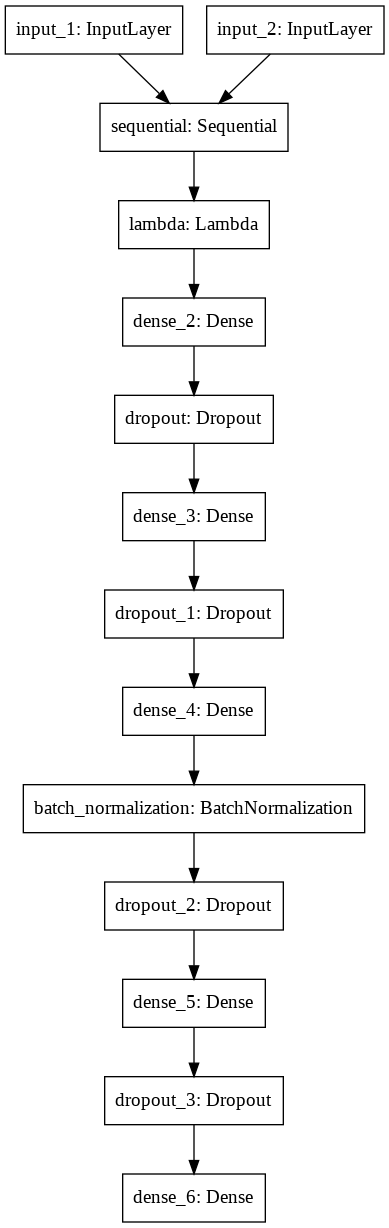

In [ ]:
siamese_net = model_builder()
tf.keras.utils.plot_model(
    siamese_net, to_file='siamese_net.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

In [ ]:
siamese_net.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          22745088    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128)          0           sequential[0][0]      

In [ ]:
epochs_to_wait_for_improve = 20
n_epochs = 100
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=epochs_to_wait_for_improve)
checkpoint_callback = ModelCheckpoint('siamese_net'+'.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = siamese_net.fit([train_image_A,train_image_B],train_labels , validation_data = ([test_image_A,test_image_B], test_labels),
            epochs=n_epochs, callbacks=[early_stopping_callback, checkpoint_callback])

Epoch 1/100
250/250 [==============================] - ETA: 0s - loss: 3.7254 - precision: 0.5725 - recall: 0.5471 - accuracy: 0.5680
Epoch 00001: val_accuracy improved from -inf to 0.57286, saving model to model.h5
250/250 [==============================] - 30s 121ms/step - loss: 3.7254 - precision: 0.5725 - recall: 0.5471 - accuracy: 0.5680 - val_loss: 2.7412 - val_precision: 0.5561 - val_recall: 0.6356 - val_accuracy: 0.5729
Epoch 2/100
250/250 [==============================] - ETA: 0s - loss: 2.3292 - precision: 0.5996 - recall: 0.5611 - accuracy: 0.5920
Epoch 00002: val_accuracy did not improve from 0.57286
250/250 [==============================] - 29s 115ms/step - loss: 2.3292 - precision: 0.5996 - recall: 0.5611 - accuracy: 0.5920 - val_loss: 1.9951 - val_precision: 0.5090 - val_recall: 0.9038 - val_accuracy: 0.5257
Epoch 3/100
250/250 [==============================] - ETA: 0s - loss: 1.7092 - precision: 0.6651 - recall: 0.5351 - accuracy: 0.6317
Epoch 00003: val_accuracy did

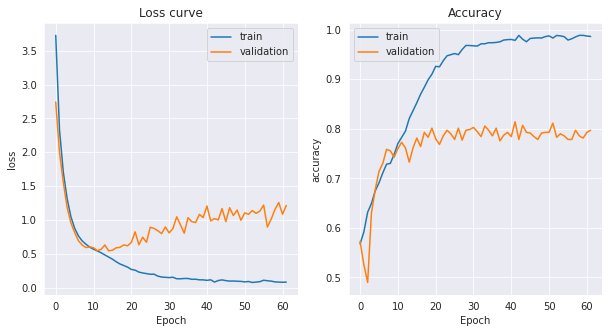

In [ ]:
sns.set_style("darkgrid")
train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

#get the entries
xvalues = np.arange(len(train_acc))

#visualise
f, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].plot(xvalues, train_loss)
ax[0].plot(xvalues, valid_loss)
ax[0].set_title("Loss curve")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("loss")
ax[0].legend(['train', 'validation'])

ax[1].plot(xvalues,  train_acc)
ax[1].plot(xvalues, valid_acc)
ax[1].set_title("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("accuracy")
ax[1].legend(['train', 'validation'])

plt.show()

In [ ]:
eval = siamese_net.evaluate([test_image_A, test_image_B], test_labels)

22/22 [==============================] - 1s 33ms/step - loss: 1.2151 - precision: 0.8274 - recall: 0.7405 - accuracy: 0.7971


In [ ]:
def get_predictions(siamese_net, test_data):
    pred = siamese_net.predict(test_data)
    predictions = []
    for i in pred:
        if i>0.5:
            predictions.append(1)
        else :
            predictions.append(0)
    predictions = np.array(predictions)        
    return predictions 

#Getting Predictions  
predictions = get_predictions(siamese_net,[test_image_A, test_image_B])

<Figure size 432x288 with 0 Axes>

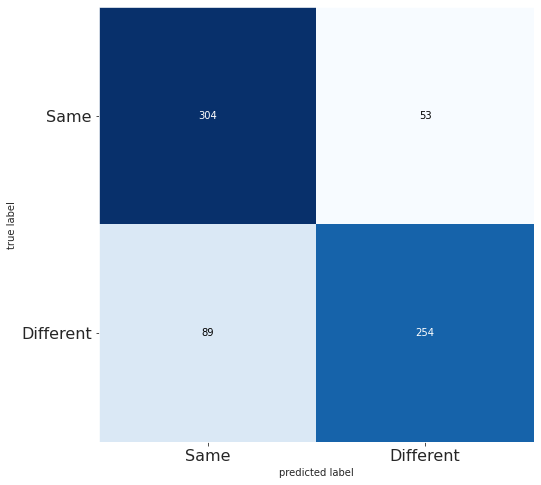

In [ ]:
#Plotting the confusion matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
cm  = confusion_matrix(test_labels, predictions)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Same', 'Different'], fontsize=16)
plt.yticks(range(2), ['Same', 'Different'], fontsize=16)
plt.show()